# Pathway activity inference

scRNA-seq yield many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by infering pathway activities from prior knowledge.

In this notebook we showcase how to use `decoupler` for pathway activity inference with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available
from 10x Genomics [here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>  

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

## Loading the data

We can download the data easily using `scanpy`:

In [2]:
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can visualize the different cell types in it:

/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


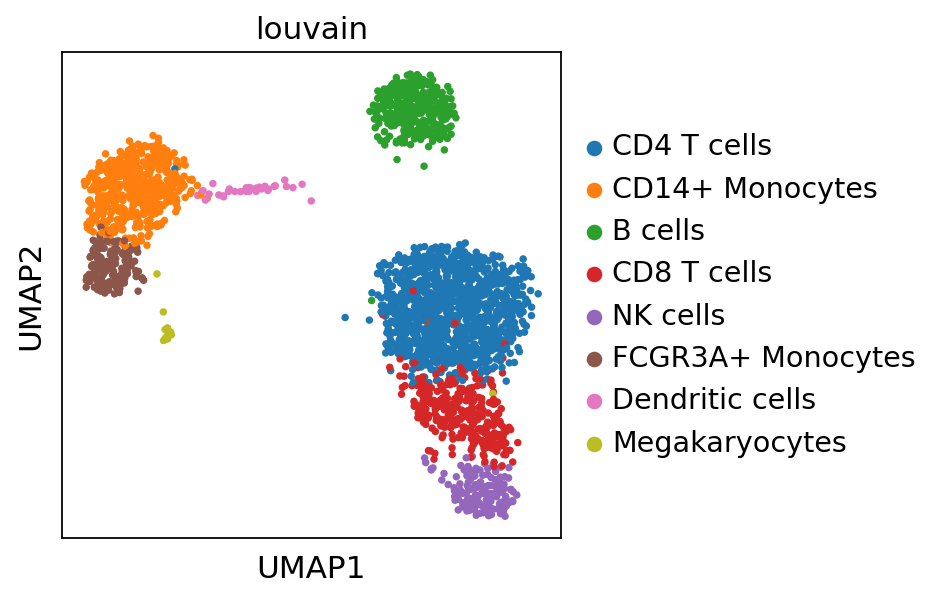

In [3]:
sc.pl.umap(adata, color='louvain')

## PROGENy model

[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction.
For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

- **Androgen**: involved in the growth and development of the male reproductive organs.
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs.
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation.
- **MAPK**: integrates external signals and promotes cell growth and proliferation.
- **NFkB**: regulates immune response, cytokine production and cell survival.
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- **PI3K**: promotes growth and proliferation.
- **TGFb**: involved in development, homeostasis, and repair of most tissues.
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- **Trail**: induces apoptosis.
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration.
- **WNT**: regulates organ morphogenesis during development and tissue repair.

To access it we can use `decoupler`.

In [4]:
progeny = dc.get_progeny(organism='human', top=500)
progeny

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
6995,p53,ZMYM4,-2.325752,1.522388e-06
6996,p53,CFDP1,-1.628168,1.526045e-06
6997,p53,VPS37D,2.309503,1.537098e-06
6998,p53,TEDC1,-2.274823,1.547037e-06


## Activity inference with multivariate linear model (MLM)

To infer pathway enrichment scores we will run the multivariate linear model (`mlm`) method. For each cell in our dataset (`adata`), it fits a linear model that predicts the observed gene expression based on all pathways' Pathway-Gene interactions weights.
Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

<img src="../mlm.png" />

To run `decoupler` methods, we need an input matrix (`mat`), an input prior knowledge
network/resource (`net`), and the name of the columns of `net` that we want to use.

In [5]:
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

1 features of mat are empty, they will be removed.
Running mlm on mat with 2638 samples and 13713 targets for 14 sources.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


The obtained scores (t-values)(`mlm_estimate`) and p-values (`mlm_pvals`) are stored in the `.obsm` key:

In [6]:
adata.obsm['mlm_estimate']

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
AAACATACAACCAC-1,0.490808,3.429084,-1.039441,1.021548,-0.191042,-2.449631,-0.320055,-0.916049,-0.124889,2.243871,-0.675080,-1.272345,1.705514,-5.722437
AAACATTGAGCTAC-1,-0.466201,2.585617,-1.352572,1.552106,1.692950,-3.814194,-1.674760,0.388031,-1.621433,2.277024,0.742877,-1.315730,0.881297,-6.952016
AAACATTGATCAGC-1,0.201594,2.639025,-1.293040,1.610743,1.638280,-2.549840,-1.316796,-0.295223,-0.578436,3.047308,-0.326156,-1.112296,0.324729,-3.138162
AAACCGTGCTTCCG-1,-1.383697,3.073606,-0.274373,0.965906,7.269398,-3.850540,-3.170332,-2.129100,-0.257945,3.647277,0.726435,-1.122516,1.512027,-3.092223
AAACCGTGTATGCG-1,0.066506,2.647741,-0.498160,0.943160,3.156663,-0.177606,0.081432,-1.506025,0.177543,0.740944,0.213525,-0.016440,0.074150,-0.240803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,-1.039859,3.378976,-0.377934,2.363054,8.334864,-3.247122,-2.990553,0.047852,0.215981,3.591358,0.035672,-1.774677,1.227447,-1.182746
TTTCTACTGAGGCA-1,1.770347,1.534039,-0.031625,0.196968,3.509904,-3.166852,-1.301823,1.392412,-1.793369,1.649786,-2.002095,-0.923002,1.033536,-2.035009
TTTCTACTTCCTCG-1,0.953103,2.150580,-1.543152,0.925286,1.706011,-2.324982,-0.933964,-1.584634,0.437537,1.805766,1.886841,-1.383962,0.689707,-5.863471
TTTGCATGAGAGGC-1,-0.716598,2.011687,-0.350687,0.933494,0.839216,-1.235606,-1.230418,-0.841037,-0.187714,1.326487,1.442059,-2.402458,1.367664,0.374511


**Note**: Each run of `run_mlm` overwrites what is inside of `mlm_estimate` and `mlm_pvals`. if you want to run `mlm` with other resources and still keep the activities inside the same `AnnData` object, you can store the results in any other key in `.obsm` with different names, for example:

In [7]:
adata.obsm['progeny_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['progeny_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Visualization

To visualize the obtained scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract the activities from the `adata` object.

In [8]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')
acts

AnnData object with n_obs × n_vars = 2638 × 14
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example let's visualise the Trail pathway:

/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


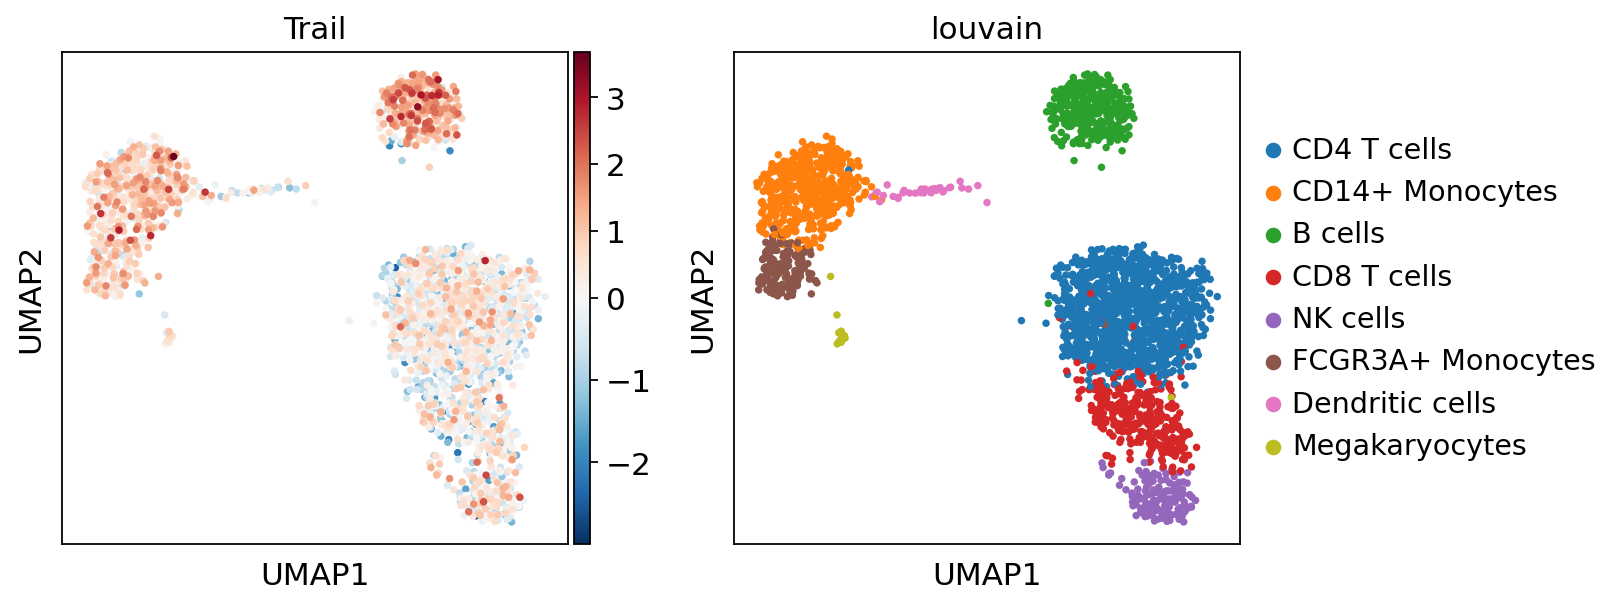

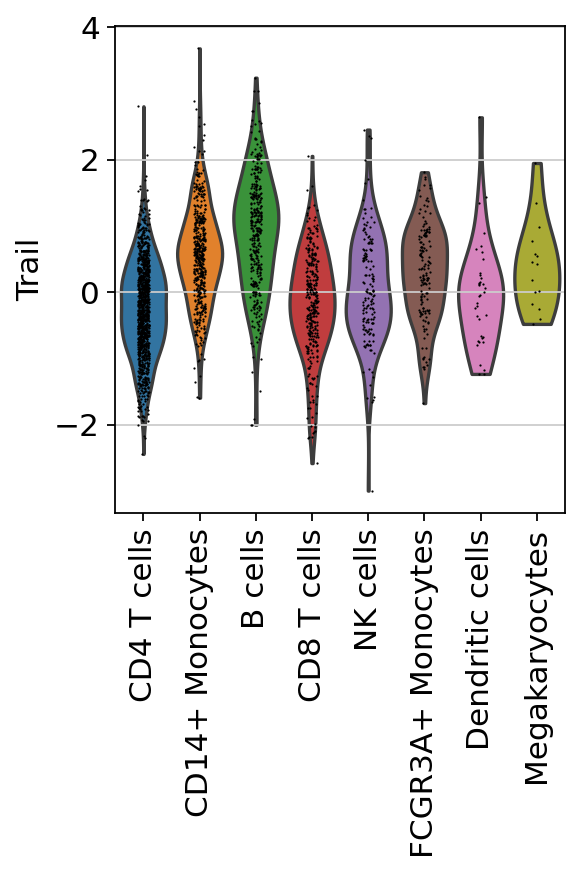

In [9]:
sc.pl.umap(acts, color=['Trail', 'louvain'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys=['Trail'], groupby='louvain', rotation=90)

It seem that in B cells, the pathway Trail, associated with apoptosis, is more active.

## Exploration

We can visualize which pathways are more active in each cell type:

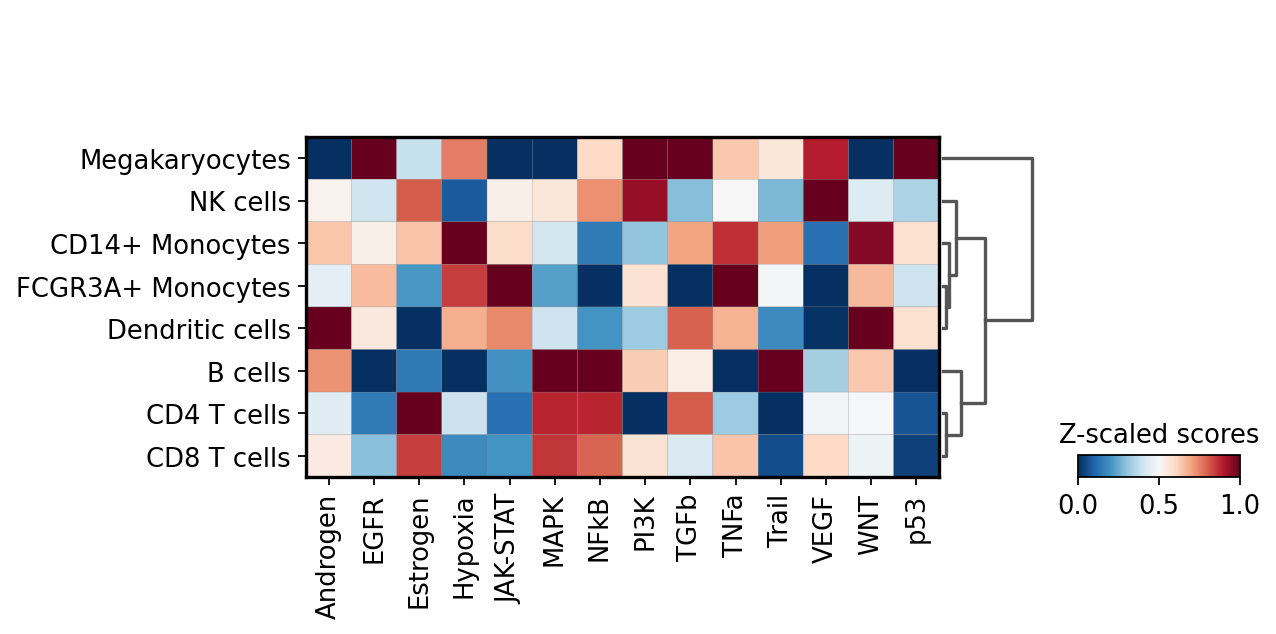

In [10]:
sc.pl.matrixplot(acts, var_names=acts.var_names, groupby='louvain', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

In this specific example, we can observe that EGFR to be more active in Megakaryocytes, and that Trail is more active in B cells.

Finally, we can check individual pathways by plotting their distributions:

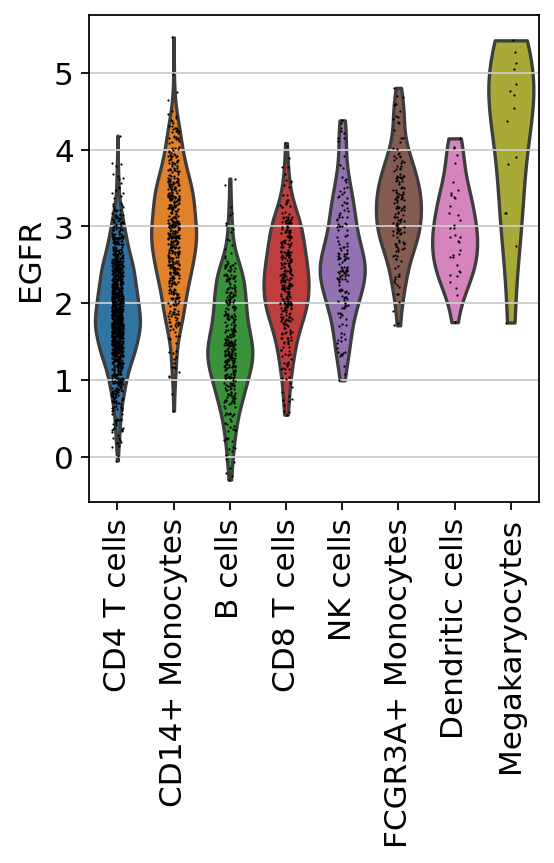

In [11]:
sc.pl.violin(acts, keys=['EGFR'], groupby='louvain', rotation=90)

<div class="alert alert-info">

**Note**
    
If your data consist of different conditions with enough samples, we recommend to work with pseudo-bulk profiles instead. Check this
[vignette](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html) for more informatin.

</div>